In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/NonIID/DirichletPartition/Decentralized/Dirichlet_Requirement.ipynb'

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.005,momentum=0.5)

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=3)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

test_accuracies = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, #Learning rate
    server_momentum=0.9 #Momentum
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1193) 2025-04-28 15:06:05.935101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1193) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1193) E0000 00:00:1745852766.017526    1193 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1193) E0000 00:00:1745852766.028978    1193 cuda_bla

(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 108855.88 examples/s]


(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(ClientAppActor pid=1193) Partition 3 size: 4835
(ClientAppActor pid=1193) Partition 3 train size: 3868
(ClientAppActor pid=1193) Partition 3 test size: 967
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 1407448884575988944, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 1: Test Accuracy: 0.3312
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 2: Test Accuracy: 0.5829
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.5480
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(ClientAppActor pid=1193) Partition 2 size: 2133
(ClientAppActor pid=1193) Partition 2 train size: 1706
(ClientAppActor pid=1193) Partition 2 test size: 427
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=119

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.4447
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=11

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 5: Test Accuracy: 0.3791
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 6: Test Accuracy: 0.5667
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 7: Test Accuracy: 0.4606
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.4465
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=11

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 9: Test Accuracy: 0.6969
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 10: Test Accuracy: 0.7047
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 11: Test Accuracy: 0.7563
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.7845
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 13: Test Accuracy: 0.7159
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.6623
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.5263
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 16: Test Accuracy: 0.7601
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 17: Test Accuracy: 0.1885
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 18: Test Accuracy: 0.6886
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
Round 19: Test Accuracy: 0.7001
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 20: Test Accuracy: 0.7303
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 1407448884575988944, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 21: Test Accuracy: 0.6619
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.7007
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 23: Test Accuracy: 0.7498
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.6794
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 25: Test Accuracy: 0.2565
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.7937
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 27: Test Accuracy: 0.7918
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 1407448884575988944, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 28: Test Accuracy: 0.4459
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 29: Test Accuracy: 0.7166
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.5479
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 31: Test Accuracy: 0.7108
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11772780122001635818, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 32: Test Accuracy: 0.8226
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.7037
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 34: Test Accuracy: 0.7768
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.7821
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(ClientAppActor pid=1193) Partition 2 size: 2133
(ClientAppActor pid=1193) Partition 2 train size: 1706
(ClientAppActor pid=1193) Partition 2 test size: 427
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 36: Test Accuracy: 0.2918
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 37: Test Accuracy: 0.6152
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.5590
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 39: Test Accuracy: 0.6791
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(ClientAppActor pid=1193) Partition 2 size: 2133
(ClientAppActor pid=1193) Partition 2 train size: 1706
(ClientAppActor pid=1193) Partition 2 test size: 427
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 40: Test Accuracy: 0.8193
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 41: Test Accuracy: 0.7617
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 3
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 42: Test Accuracy: 0.7431
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.5844
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 44: Test Accuracy: 0.6246
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 45: Test Accuracy: 0.7315
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11772780122001635818, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Cli

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=1193, ip=172.28.0.12, actor_id=9386ebf82c7358cc9f642c3501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x789c31b1dcd0>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=1193, ip=172.28.0.12, actor_id=9386ebf82c7358cc9f642c3501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x789c31b1dcd0>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, con

(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.7707
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11772780122001635818, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 47: Test Accuracy: 0.8225
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 10018307684955466053, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cli

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 48: Test Accuracy: 0.7838
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 7076906941648784688, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(ClientAppActor pid=1193) Partition 8 size: 19003
(ClientAppActor pid=1193) Partition 8 train size: 15202
(ClientAppActor pid=1193) Partition 8 test size: 3801
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11772780122001635818, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 49: Test Accuracy: 0.7477
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11270805442987982674, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 4
(ClientAppActor pid=1193) Partition 4 size: 7143
(ClientAppActor pid=1193) Partition 4 train size: 5714
(ClientAppActor pid=1193) Partition 4 test size: 1429
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 8417067320238907798, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 4033103636878516382, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 2
(ClientAppActor pid=1193) Partition 2 size: 2133
(ClientAppActor pid=1193) Partition 2 train size: 1706
(ClientAppActor pid=1193) Partition 2 test size: 427
(ClientAppActor pid=1193) Context data: {'run_id': 12977528223410955623, 'node_id': 11772780122001635818, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1193)   array_records={},
(ClientAppActor pid=1193)   metric_records={},
(ClientAppActor pid=1193)   config_records={}
(ClientAppActor pid=1193) ), 'run_config': {}}
(ClientAppActor pid=1193) Using partition_id: 8
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 6872.07s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07872283464251034
INFO :      		round 2: 0.11878115904326603
INFO :      		round 3: 0.14618123552073609
INFO :      		round 4: 0.05371255341602054
INFO :      		round 5: 0.05461424907759272
INFO :      		round 6: 0.05252772229720424
INFO :      		round 7: 0.12298179675960366
INFO :      		round 8: 0.09825984911104495
INFO :      		round 9: 0.03187310472863726
INFO :      		round 10: 0.033006174700267295
INFO :      		round 11: 0.032622135574169354
INFO :      		round 12: 0.02967986518151009
INFO :      		round 13: 0.04901992922783481
INFO :      		round 14: 0.05419938269663269
INFO :      		round 15: 0.0805240982450962
INFO :      		round 16: 0.03716308830210247
INFO :      		round 17: 0.16914319413120188
INFO :      		round 18: 0.05276920574222321
INFO :      		round 19: 

(ClientAppActor pid=1193) Partition 1 size: 940
(ClientAppActor pid=1193) Partition 1 train size: 752
(ClientAppActor pid=1193) Partition 1 test size: 188
Round 50: Test Accuracy: 0.6653


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.3312
Round 2: 0.5829
Round 3: 0.5480
Round 4: 0.4447
Round 5: 0.3791
Round 6: 0.5667
Round 7: 0.4606
Round 8: 0.4465
Round 9: 0.6969
Round 10: 0.7047
Round 11: 0.7563
Round 12: 0.7845
Round 13: 0.7159
Round 14: 0.6623
Round 15: 0.5263
Round 16: 0.7601
Round 17: 0.1885
Round 18: 0.6886
Round 19: 0.7001
Round 20: 0.7303
Round 21: 0.6619
Round 22: 0.7007
Round 23: 0.7498
Round 24: 0.6794
Round 25: 0.2565
Round 26: 0.7937
Round 27: 0.7918
Round 28: 0.4459
Round 29: 0.7166
Round 30: 0.5479
Round 31: 0.7108
Round 32: 0.8226
Round 33: 0.7037
Round 34: 0.7768
Round 35: 0.7821
Round 36: 0.2918
Round 37: 0.6152
Round 38: 0.5590
Round 39: 0.6791
Round 40: 0.8193
Round 41: 0.7617
Round 42: 0.7431
Round 43: 0.5844
Round 44: 0.6246
Round 45: 0.7315
Round 46: 0.7707
Round 47: 0.8225
Round 48: 0.7838
Round 49: 0.7477
Round 50: 0.6653



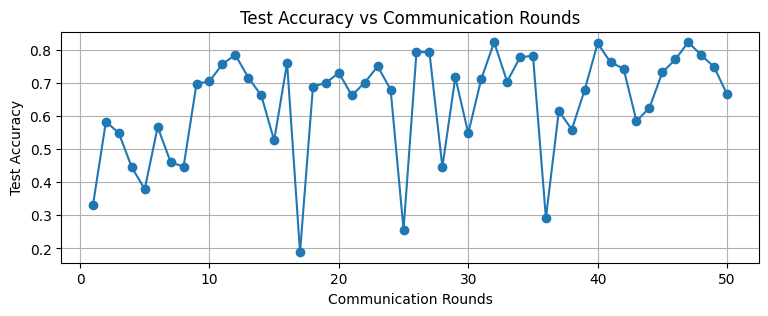

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()